In [68]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import numpy as np
import os
from sklearn import metrics
import json
import re
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
import plotly as py
import plotly.graph_objects as go
from sklearn.decomposition import PCA #Principal Component Analysis
import json
import os

In [69]:
'''
The function is used to the clusters using PDA
'''
def plot_PCA(plotS, num_clusters, num_dim, information):
    colors = ['#0000ff','#000000', '#ffff66', '#00ff00', '#ff0000', '#ff00ff', '#663300', '#ff66ff', '#00ccff', 
    "#e1a42b", "#657a2f" , "#00735b" , "#7a2f65" , "#442f7a" , "#005a80" , "#335853" , "#81254c" , "#483c6a" , "#2f657a" ,
     "#c88f1c" , "#fbb5df" , "#80001a" , "#d5d0ca" , "#196b6b"]
    
    #PCA with one principal component
    pca_1d = PCA(n_components=1)

    #PCA with two principal components
    pca_2d = PCA(n_components=2)

    #PCA with three principal components
    pca_3d = PCA(n_components=3)
    
    
    PCs_1d = pd.DataFrame(pca_1d.fit_transform(plotS.drop(["cluster"], axis=1)), index=plotS.index)

    PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotS.drop(["cluster"], axis=1)), index=plotS.index)

    PCs_3d = pd.DataFrame(pca_3d.fit_transform(plotS.drop(["cluster"], axis=1)), index=plotS.index)
    
    PCs_1d.columns = ["PC1_1d"]

    PCs_2d.columns = ["PC1_2d", "PC2_2d"]

    PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]
    
    plotS = pd.concat([plotS,PCs_1d,PCs_2d,PCs_3d], axis=1, join='inner')
    plotS["dummy"] = 0
    
    clusters = []
    for i in range(num_clusters):
        clusters.append(plotS[plotS["cluster"] == i])
        
    traces = []
    for i in range(num_clusters):
        if num_dim == 3:
            traces.append(go.Scatter3d(
            x = clusters[i]["PC1_3d"],
            y = clusters[i]["PC2_3d"],
            z = clusters[i]["PC3_3d"],
            mode = "markers",
            name = "Cluster {}".format(i),
            marker = dict(color = colors[i])
                ,text = None)
                         )
        else: 
            traces.append(go.Scatter(
            x = clusters[i]["PC1_2d"],
            y = clusters[i]["PC2_2d"],
            mode = "markers",
            name = "Cluster {}".format(i),
            marker = dict(color = colors[i]),text = None)
                         )
        
    data = traces
    
    title = "Cluster Visualization {}-Dimension".format(num_dim)

    layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

    fig = go.Figure(data = data, layout = layout)

    fig.show(width=100, height=100)
    return PCs_1d, PCs_2d, PCs_3d

<h2>Load Dataset and Preprocessing</h2>

In [70]:
#get json file with the condo
dir = "/home/giuseppe/Scrivania/condos.json"
if os.path.isfile(dir):
    file = json.load(open(dir))


In [71]:
df = pd.DataFrame()
condos = file

regnumber = re.compile(r'\d+(?:,\d*)?')
regstring = re.compile(r"\w* \s* \w*")

for condo in condos:
    rlist = {}
    if condo["uuid"]:
        rlist["uuid"] = condo["uuid"]
    if condo["attributes"]:
        for attr in condo["attributes"]:
            if len(condo["attributes"][attr]) <= 10:
                #check if is an number
                if regnumber.match(str(condo["attributes"][attr])):
                    try:
                        rlist[attr] = float(condo["attributes"][attr].replace(",", "."))
                    except:
                        rlist[attr] = condo["attributes"][attr]

                #chck if is string
                if regstring.match(str(condo["attributes"][attr])):
                    rlist[attr] = condo["attributes"][attr]
    if condo["location"]:
        rlist["coordinate_X"] = condo["location"]["coordinates"][0]
        rlist["coordinate_Y"] = condo["location"]["coordinates"][1]



    df_dic = pd.DataFrame([rlist])
    df = pd.concat([df, df_dic], ignore_index=True)

df.set_index("uuid")
df.head()

,uuid,FLOOR,ESTATE_SIZE/GROSS_AREA,AVAILABLE_DATE_FREETEXT,ESTATE_SIZE/USEABLE_AREA,PROPERTY_TYPE_ID,ESTATE_SIZE/LIVING_AREA,ESTATE_PRICE/PRICE_SUGGESTION,UNIT_NUMBER,ENERGY_HWB,...,ADDITIONAL_COST/AMOUNT,PLOT/AREA,INFOLINK/NAME,OLD_PRICE,CONTACT/IMMOCARD_COMPANY_ID,ADDITIONAL_COST/AMOUNT_NET,ESTATE_PRICE/MONTHCOSTS_VAT,ENERGY_HWB_CLASS,RENTAL_PRICE/FURNITURE_COST,ESTATE_PRICE/PRICE_DESCRIPTION
0,083c82b6-ec42-4944-beb4-a6ca8aa3da02,6.0,81.72,2024.0,81.72,3.0,69.36,425000.00,42.0,25.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,effb8463-6284-4be4-841d-a6ca8aa3da02,4.0,65.02,NaN,65.02,3.0,65.15,375000.15,17.0,28.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,03d40a26-97a0-4ee8-a456-a6ca8aa3da02,NaN,NaN,NaN,NaN,3.0,114.61,1155000.00,NaN,42.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,74089b09-d4d3-4def-a9ca-b34e9d305250,28.0,NaN,NaN,NaN,3.0,101.54,1039940.00,2.0,23.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9a7a65f7-033e-4d5c-b5c3-a6ca8aa3da02,NaN,NaN,NaN,NaN,3.0,46.33,485000.00,NaN,42.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 51 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   uuid                            1249 non-null   object 
 1   FLOOR                           966 non-null    object 
 2   ESTATE_SIZE/GROSS_AREA          383 non-null    float64
 3   AVAILABLE_DATE_FREETEXT         157 non-null    object 
 4   ESTATE_SIZE/USEABLE_AREA        507 non-null    float64
 5   PROPERTY_TYPE_ID                1249 non-null   float64
 6   ESTATE_SIZE/LIVING_AREA         1232 non-null   float64
 7   ESTATE_PRICE/PRICE_SUGGESTION   1216 non-null   float64
 8   UNIT_NUMBER                     558 non-null    object 
 9   ENERGY_HWB                      1047 non-null   float64
 10  CONSTRUCTION_YEAR               605 non-null    float64
 11  FREE_AREA/FREE_AREA_AREA        650 non-null    float64
 12  ENERGY_FGEE                     64

In [73]:
df.dropna(axis = "columns", how="all", thresh=df.shape[0] * 0.7) #70% value not null
drop_features = ["IMPORT_EXTERNAL_ADVERTISER_ID", "AVAILABLE_DATE_FREETEXT", "CONTACT/PHONE" , "UNIT_NUMBER"]
df.drop(drop_features, inplace=True, axis=1)

array([[<AxesSubplot:title={'center':'ESTATE_SIZE/GROSS_AREA'}>,
        <AxesSubplot:title={'center':'ESTATE_SIZE/USEABLE_AREA'}>,
        <AxesSubplot:title={'center':'PROPERTY_TYPE_ID'}>,
        <AxesSubplot:title={'center':'ESTATE_SIZE/LIVING_AREA'}>,
        <AxesSubplot:title={'center':'ESTATE_PRICE/PRICE_SUGGESTION'}>,
        <AxesSubplot:title={'center':'ENERGY_HWB'}>],
       [<AxesSubplot:title={'center':'CONSTRUCTION_YEAR'}>,
        <AxesSubplot:title={'center':'FREE_AREA/FREE_AREA_AREA'}>,
        <AxesSubplot:title={'center':'ENERGY_FGEE'}>,
        <AxesSubplot:title={'center':'NO_OF_ROOMS'}>,
        <AxesSubplot:title={'center':'PRICE'}>,
        <AxesSubplot:title={'center':'REGION_AREA_ID'}>],
       [<AxesSubplot:title={'center':'POSITION_RADIUS_METERS'}>,
        <AxesSubplot:title={'center':'CONTACT/ADDRESS_POSTCODE'}>,
        <AxesSubplot:title={'center':'ISPRIVATE'}>,
        <AxesSubplot:title={'center':'DEALER'}>,
        <AxesSubplot:title={'center':'ORG_T

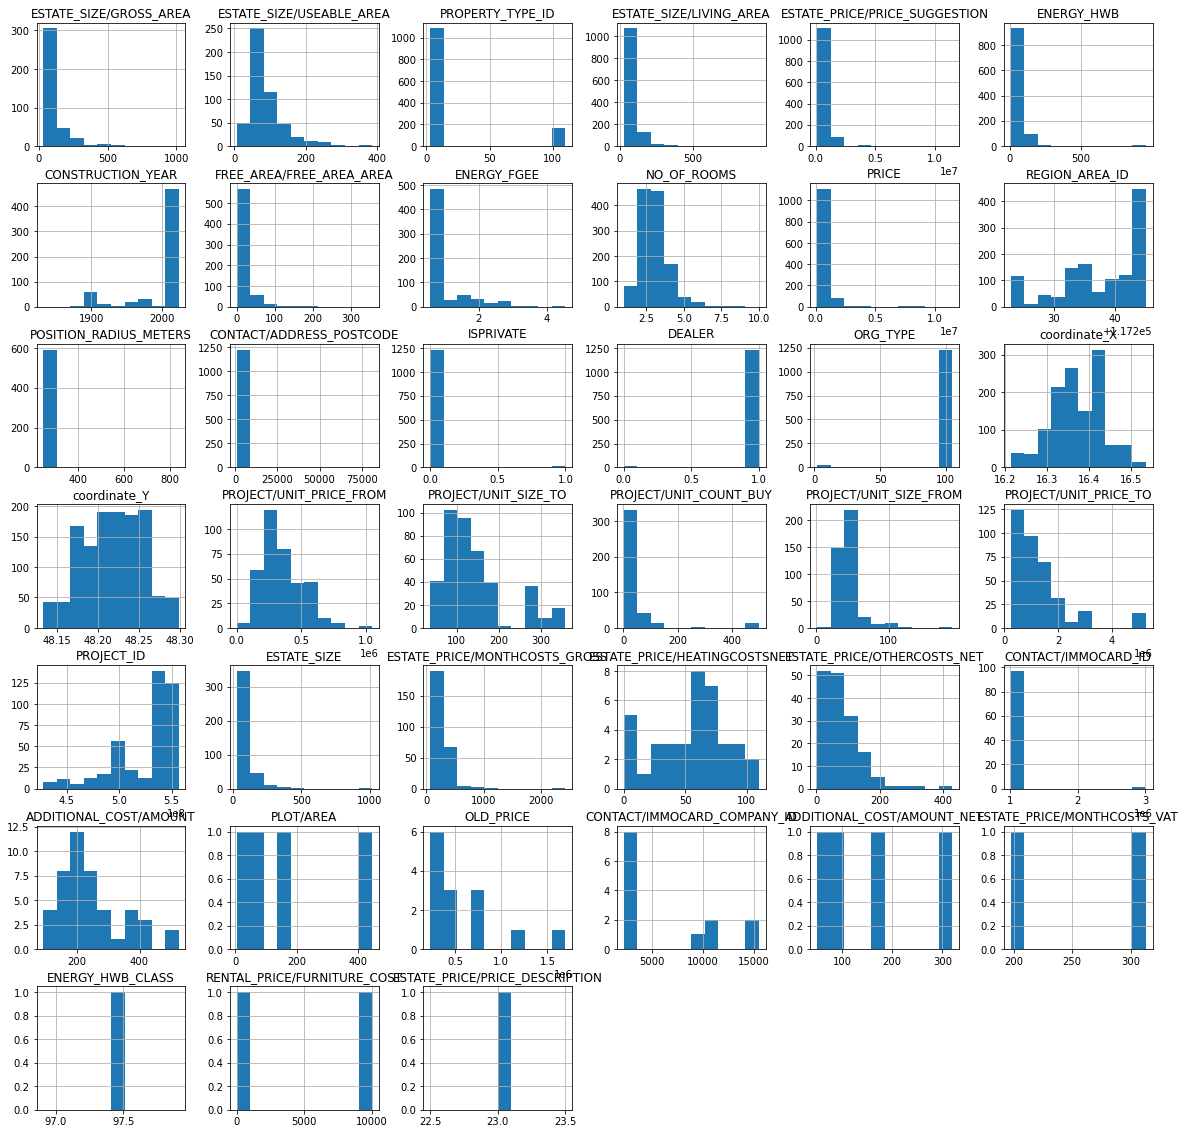

In [74]:
df.hist(figsize=(20,20))

In [75]:
#delete the feature where every entry belongs to one class
df.drop(["ENERGY_HWB_CLASS", "ESTATE_PRICE/PRICE_DESCRIPTION" , "ISPRIVATE", "CONTACT/ADDRESS_POSTCODE", "POSITION_RADIUS_METERS", "DEALER"], inplace= True, axis=1)

In [67]:
#correlation analysis
attributes = df.columns
scatter_matrix(df[attributes], figsize=(15, 10))

array([[<AxesSubplot:xlabel='ESTATE_SIZE/GROSS_AREA', ylabel='ESTATE_SIZE/GROSS_AREA'>,
        <AxesSubplot:xlabel='ESTATE_SIZE/USEABLE_AREA', ylabel='ESTATE_SIZE/GROSS_AREA'>,
        <AxesSubplot:xlabel='PROPERTY_TYPE_ID', ylabel='ESTATE_SIZE/GROSS_AREA'>,
        ...,
        <AxesSubplot:xlabel='ADDITIONAL_COST/AMOUNT_NET', ylabel='ESTATE_SIZE/GROSS_AREA'>,
        <AxesSubplot:xlabel='ESTATE_PRICE/MONTHCOSTS_VAT', ylabel='ESTATE_SIZE/GROSS_AREA'>,
        <AxesSubplot:xlabel='RENTAL_PRICE/FURNITURE_COST', ylabel='ESTATE_SIZE/GROSS_AREA'>],
       [<AxesSubplot:xlabel='ESTATE_SIZE/GROSS_AREA', ylabel='ESTATE_SIZE/USEABLE_AREA'>,
        <AxesSubplot:xlabel='ESTATE_SIZE/USEABLE_AREA', ylabel='ESTATE_SIZE/USEABLE_AREA'>,
        <AxesSubplot:xlabel='PROPERTY_TYPE_ID', ylabel='ESTATE_SIZE/USEABLE_AREA'>,
        ...,
        <AxesSubplot:xlabel='ADDITIONAL_COST/AMOUNT_NET', ylabel='ESTATE_SIZE/USEABLE_AREA'>,
        <AxesSubplot:xlabel='ESTATE_PRICE/MONTHCOSTS_VAT', ylabel='ESTATE_S

Error in callback <function flush_figures at 0x7f72eec26f80> (for post_execute):


KeyboardInterrupt: 

In [76]:
#create a corr matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Drop features 
df.drop(to_drop, axis=1, inplace=True)


/tmp/ipykernel_3588/2942579641.py:5: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   uuid                           1249 non-null   object 
 1   FLOOR                          966 non-null    object 
 2   ESTATE_SIZE/GROSS_AREA         383 non-null    float64
 3   PROPERTY_TYPE_ID               1249 non-null   float64
 4   ESTATE_SIZE/LIVING_AREA        1232 non-null   float64
 5   ESTATE_PRICE/PRICE_SUGGESTION  1216 non-null   float64
 6   ENERGY_HWB                     1047 non-null   float64
 7   CONSTRUCTION_YEAR              605 non-null    float64
 8   FREE_AREA/FREE_AREA_AREA       650 non-null    float64
 9   ENERGY_FGEE                    642 non-null    float64
 10  NO_OF_ROOMS                    1235 non-null   float64
 11  REGION_AREA_ID                 1247 non-null   float64
 12  ORG_TYPE                       1249 non-null   f

In [78]:
df.mean()

/tmp/ipykernel_3588/3698961737.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



ESTATE_SIZE/GROSS_AREA           1.084874e+02
PROPERTY_TYPE_ID                 1.657646e+01
ESTATE_SIZE/LIVING_AREA          8.071843e+01
ESTATE_PRICE/PRICE_SUGGESTION    6.702888e+05
ENERGY_HWB                       5.445777e+01
CONSTRUCTION_YEAR                2.000319e+03
FREE_AREA/FREE_AREA_AREA         1.879400e+01
ENERGY_FGEE                      1.077625e+00
NO_OF_ROOMS                      2.798785e+00
REGION_AREA_ID                   1.172375e+05
ORG_TYPE                         1.033507e+02
coordinate_X                     1.637403e+01
coordinate_Y                     4.821802e+01
PROJECT/UNIT_PRICE_FROM          3.578089e+05
PROJECT/UNIT_SIZE_TO             1.424469e+02
PROJECT/UNIT_COUNT_BUY           4.858333e+01
PROJECT/UNIT_SIZE_FROM           4.507529e+01
PROJECT_ID                       5.247924e+08
ESTATE_PRICE/OTHERCOSTS_NET      7.997225e+01
CONTACT/IMMOCARD_ID              1.029457e+06
ADDITIONAL_COST/AMOUNT           2.452476e+02
dtype: float64

In [79]:
#get only the numeric value in the dataframe
dfs = df.select_dtypes(include=np.number)

#scaling the value
scaler = StandardScaler()

dfs = pd.DataFrame(scaler.fit_transform(dfs), index=dfs.index, columns = dfs.columns)
dfs.mean()

ESTATE_SIZE/GROSS_AREA          -3.246605e-17
PROPERTY_TYPE_ID                 8.248895e-17
ESTATE_SIZE/LIVING_AREA          1.787892e-16
ESTATE_PRICE/PRICE_SUGGESTION   -2.921640e-17
ENERGY_HWB                      -7.889264e-17
CONSTRUCTION_YEAR                1.761676e-17
FREE_AREA/FREE_AREA_AREA        -1.093143e-17
ENERGY_FGEE                      5.257131e-17
NO_OF_ROOMS                     -1.668481e-16
REGION_AREA_ID                  -4.523670e-13
ORG_TYPE                        -5.688893e-18
coordinate_X                    -9.037518e-15
coordinate_Y                    -1.390764e-13
PROJECT/UNIT_PRICE_FROM          9.576048e-17
PROJECT/UNIT_SIZE_TO             8.707632e-17
PROJECT/UNIT_COUNT_BUY          -1.088454e-17
PROJECT/UNIT_SIZE_FROM          -1.589143e-16
PROJECT_ID                       1.915679e-16
ESTATE_PRICE/OTHERCOSTS_NET     -3.885781e-17
CONTACT/IMMOCARD_ID              1.812609e-16
ADDITIONAL_COST/AMOUNT           1.544658e-16
dtype: float64

array([[<AxesSubplot:title={'center':'ESTATE_SIZE/GROSS_AREA'}>,
        <AxesSubplot:title={'center':'PROPERTY_TYPE_ID'}>,
        <AxesSubplot:title={'center':'ESTATE_SIZE/LIVING_AREA'}>,
        <AxesSubplot:title={'center':'ESTATE_PRICE/PRICE_SUGGESTION'}>,
        <AxesSubplot:title={'center':'ENERGY_HWB'}>],
       [<AxesSubplot:title={'center':'CONSTRUCTION_YEAR'}>,
        <AxesSubplot:title={'center':'FREE_AREA/FREE_AREA_AREA'}>,
        <AxesSubplot:title={'center':'ENERGY_FGEE'}>,
        <AxesSubplot:title={'center':'NO_OF_ROOMS'}>,
        <AxesSubplot:title={'center':'REGION_AREA_ID'}>],
       [<AxesSubplot:title={'center':'ORG_TYPE'}>,
        <AxesSubplot:title={'center':'coordinate_X'}>,
        <AxesSubplot:title={'center':'coordinate_Y'}>,
        <AxesSubplot:title={'center':'PROJECT/UNIT_PRICE_FROM'}>,
        <AxesSubplot:title={'center':'PROJECT/UNIT_SIZE_TO'}>],
       [<AxesSubplot:title={'center':'PROJECT/UNIT_COUNT_BUY'}>,
        <AxesSubplot:title={'center

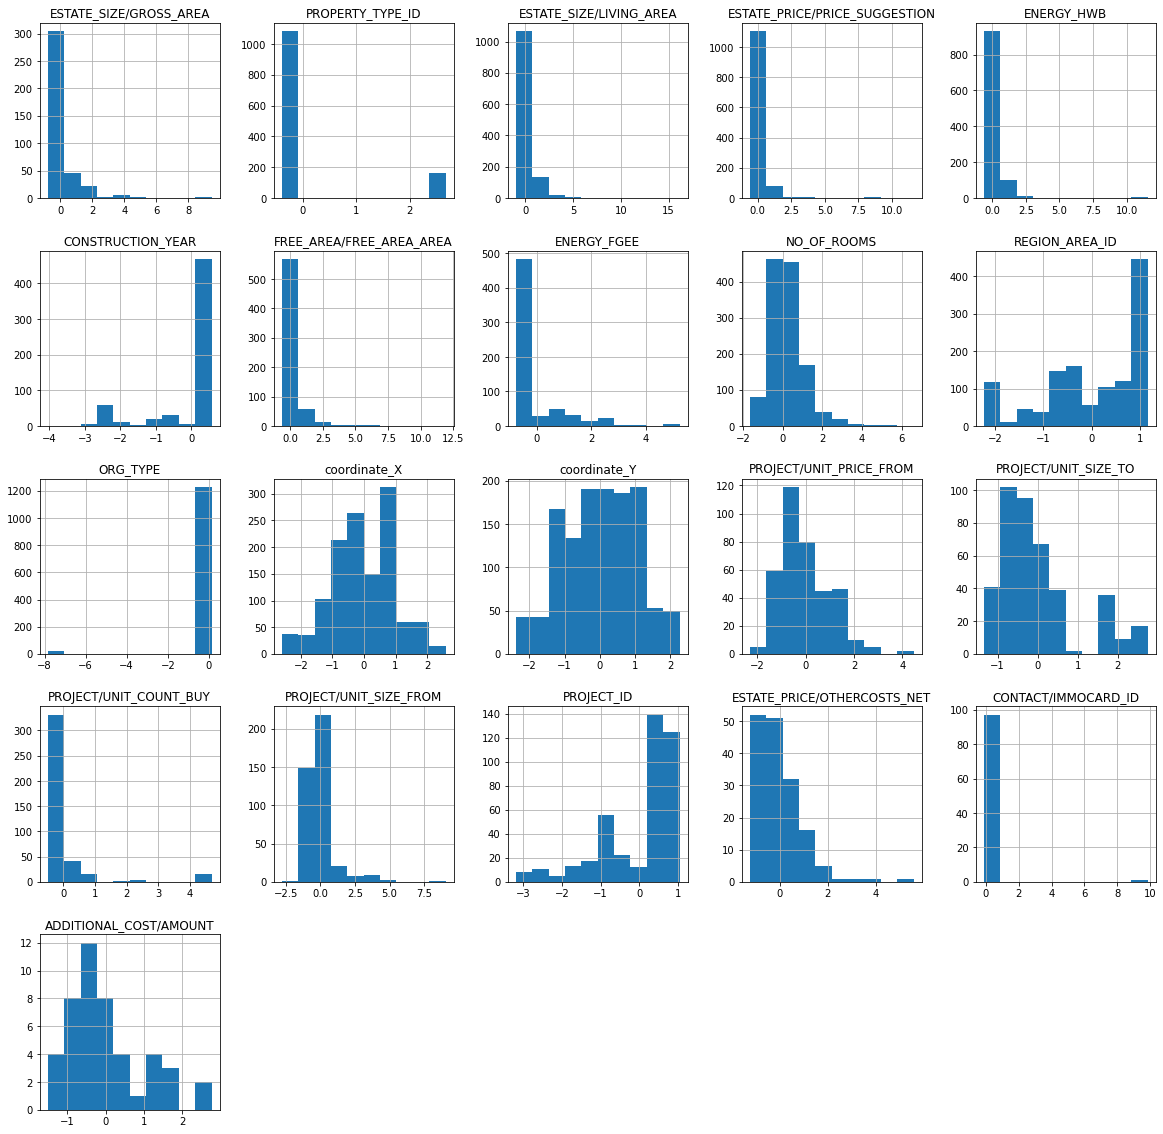

In [80]:
dfs.hist(figsize=(20,20))

In [81]:
dfs.drop(["CONTACT/IMMOCARD_ID" , "PROJECT_ID"], inplace=True, axis="columns")

In [82]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ESTATE_SIZE/GROSS_AREA         383 non-null    float64
 1   PROPERTY_TYPE_ID               1249 non-null   float64
 2   ESTATE_SIZE/LIVING_AREA        1232 non-null   float64
 3   ESTATE_PRICE/PRICE_SUGGESTION  1216 non-null   float64
 4   ENERGY_HWB                     1047 non-null   float64
 5   CONSTRUCTION_YEAR              605 non-null    float64
 6   FREE_AREA/FREE_AREA_AREA       650 non-null    float64
 7   ENERGY_FGEE                    642 non-null    float64
 8   NO_OF_ROOMS                    1235 non-null   float64
 9   REGION_AREA_ID                 1247 non-null   float64
 10  ORG_TYPE                       1249 non-null   float64
 11  coordinate_X                   1249 non-null   float64
 12  coordinate_Y                   1249 non-null   f

In [83]:
dfs.drop(["ESTATE_SIZE/GROSS_AREA" , "ADDITIONAL_COST/AMOUNT" , "PROJECT/UNIT_PRICE_FROM" , "PROJECT/UNIT_SIZE_TO" , "PROJECT/UNIT_COUNT_BUY" , "PROJECT/UNIT_SIZE_FROM" , "ESTATE_PRICE/OTHERCOSTS_NET" , "ORG_TYPE"], inplace=True, axis=1)

<h2>Clustering</h2>

<h3>DBSCAN</h3>


In [84]:
#DBSCAN

#Fill all the NAN
df_dbscan = dfs.fillna(dfs.mean())

dbscan = DBSCAN(eps=0.000005, min_samples=3)
df_clust = dbscan.fit(df_dbscan)

core_samples_mask = np.zeros_like(df_clust.labels_, dtype=bool)
core_samples_mask[df_clust.core_sample_indices_] = True
labels = df_clust.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(df_dbscan, labels))

Estimated number of clusters: 2
Estimated number of noise points: 1243
Silhouette Coefficient: -0.048


In [85]:
df_dbscan_c = df_dbscan
df_dbscan_c["cluster"] = labels
df_dbscan_c["uuid"] = df["uuid"]
df_dbscan_c.set_index("uuid")
df_dbscan_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   PROPERTY_TYPE_ID               1249 non-null   float64
 1   ESTATE_SIZE/LIVING_AREA        1249 non-null   float64
 2   ESTATE_PRICE/PRICE_SUGGESTION  1249 non-null   float64
 3   ENERGY_HWB                     1249 non-null   float64
 4   CONSTRUCTION_YEAR              1249 non-null   float64
 5   FREE_AREA/FREE_AREA_AREA       1249 non-null   float64
 6   ENERGY_FGEE                    1249 non-null   float64
 7   NO_OF_ROOMS                    1249 non-null   float64
 8   REGION_AREA_ID                 1249 non-null   float64
 9   coordinate_X                   1249 non-null   float64
 10  coordinate_Y                   1249 non-null   float64
 11  cluster                        1249 non-null   int64  
 12  uuid                           1249 non-null   o

In [86]:
{i: df_dbscan_c.iloc[np.where(labels == i)][["uuid"]] for i in range(n_clusters_)}

{0:                                      uuid
 58   9c8e48ea-e08c-4bd8-9264-a6ca8aa3da02
 296  af404561-1fcf-4541-b2cc-a6ca8aa3da02
 702  c753615c-d382-4263-8d72-a6ca8aa3da02,
 1:                                      uuid
 84   3cbbbc46-e859-40dd-b895-b34e9d305250
 526  5ea4fe12-3981-4dea-94f9-a6ca8aa3da02
 939  af20c5df-25c1-468a-9dbf-b34e9d305250}

<h3>Kmeans</h3>

In [87]:
#kmeans
df_kmeans = dfs.fillna(dfs.mean())
df_kmeans_plot = df_kmeans.copy()
kmeans = KMeans(n_clusters=23, random_state=0)

df_kmeans_plot["cluster"] = kmeans.fit_predict(df_kmeans)
df_mean_3d = df_kmeans_plot.copy()
df_kmeans_plot["uuid"] = df["uuid"]
df_kmeans_plot.set_index("uuid")
kmeans.inertia_

2677.383348667151

<h3>Parameter Tuning</h3>

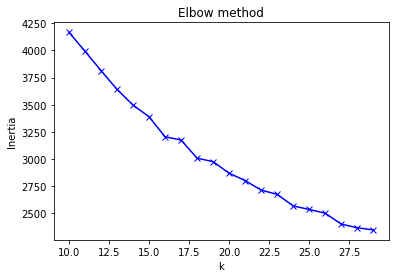

In [88]:
#tuning
inertia = []
K = range(10, 30)
for k in K:
    kmean_model = KMeans(n_clusters=k).fit(df_kmeans)
    inertia.append(kmean_model.inertia_)

#plot
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title("Elbow method", loc="center")

plt.show()

In [89]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_kmeans)
                for k in K]

silhouette_scores = [silhouette_score(df_kmeans, model.labels_)
                     for model in kmeans_per_k]


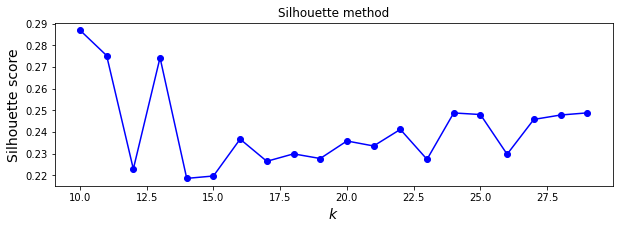

In [90]:
plt.figure(figsize=(10, 3))
plt.plot(K, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette method", loc="center")
plt.show()

<h2>PCA</h2>

In [91]:
PCs_1d, PCs_2d, PCs_3d = plot_PCA(df_mean_3d ,20,3, "Clustering")

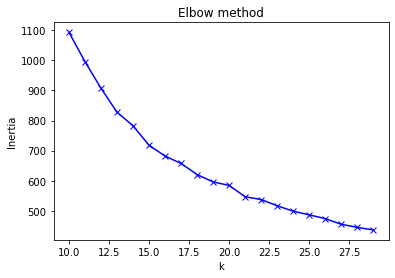

In [92]:
#PCs_3d["uuid"] = df_kmeans_plot["uuid"]
PCs_3d

#cluster based on PCA
#tuning
inertia = []
K = range(10, 30)
for k in K:
    kmean_model = KMeans(n_clusters=k).fit(PCs_3d)
    inertia.append(kmean_model.inertia_)

#plot
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title("Elbow method", loc="center")

plt.show()


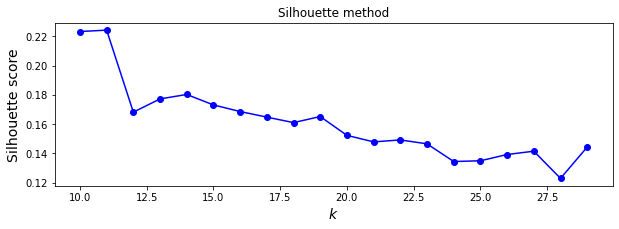

In [93]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(PCs_3d)
                for k in K]

silhouette_scores = [silhouette_score(df_kmeans, model.labels_)
                     for model in kmeans_per_k]

plt.figure(figsize=(10, 3))
plt.plot(K, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette method", loc="center")
plt.show()

In [94]:
#see the explained variance after PCA
pca_3d = PCA(n_components=3)
PCs_3d = pd.DataFrame(pca_3d.fit_transform(df_mean_3d.drop(["cluster"], axis=1)), index=df_mean_3d.index)
pca_3d.explained_variance_ratio_

array([0.28043616, 0.18490857, 0.11526807])

In [95]:
#kmeans cluster with the best parameter
PCs_3d_cluster = PCs_3d.copy()
kmeans = KMeans(n_clusters=19, random_state=42)

PCs_3d_cluster["cluster"] = kmeans.fit_predict(PCs_3d_cluster)
PCs_3d_cluster["uuid"] = df["uuid"]
PCs_3d_cluster.set_index("uuid")

,0,1,2,cluster
uuid,,,,
083c82b6-ec42-4944-beb4-a6ca8aa3da02,-1.042533,1.343809,0.225624,2
effb8463-6284-4be4-841d-a6ca8aa3da02,-0.204278,-1.309291,-0.450022,8
03d40a26-97a0-4ee8-a456-a6ca8aa3da02,1.552205,-0.630149,-0.421660,7
74089b09-d4d3-4def-a9ca-b34e9d305250,1.431024,-0.095175,-0.187940,7
9a7a65f7-033e-4d5c-b5c3-a6ca8aa3da02,-0.270455,-1.618994,-0.790740,8
...,...,...,...,...
5b000b85-5234-4484-8859-b80186fc3b9f,8.551277,3.013275,1.820747,12
d22b0aee-fbc3-4745-95f7-a6ca8aa3da02,-0.665132,-2.217977,0.378872,18
00655fc4-224d-45c5-9e66-a6ca8aa3da02,-0.467994,-1.484012,-0.532911,8


In [96]:
#{i: PCs_3d_cluster.iloc[np.where(kmeans.labels_ == i)][["uuid"]] for i in range(kmeans.n_clusters)}
clus = {i: list(PCs_3d_cluster[PCs_3d_cluster["cluster"] == i]["uuid"]) for i in range(kmeans.n_clusters)}


In [97]:
#export cluster as json file
json_file = json.dumps(clus, indent = 4)
file =  f = open("/home/giuseppe/github-classroom/kglab-tuwien/your-project-real-estate-advisor/notebooks/clusters.json", "w")
f.write(json_file)
f.close()